In [1]:
#clustering


import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import k_means


class RSC:
    """
    Implementation of the method proposed in the paper:
    'Robust Spectral Clustering for Noisy Data: Modeling Sparse Corruptions Improves Latent Embeddings'
    If you publish material based on algorithms or evaluation measures obtained from this code,
    then please note this in your acknowledgments and please cite the following paper:
        Aleksandar Bojchevski, Yves Matkovic, and Stephan Günnemann.
        2017. Robust Spectral Clustering for Noisy Data.
        In Proceedings of KDD’17, August 13–17, 2017, Halifax, NS, Canada.
    Copyright (C) 2017
    Aleksandar Bojchevski
    Yves Matkovic
    Stephan Günnemann
    Technical University of Munich, Germany
    """

    def __init__(self, k, nn=15, theta=20, m=0.5, laplacian=1, n_iter=15, normalize=False, verbose=False):
        """
        :param k: number of clusters
        :param nn: number of neighbours to consider for constructing the KNN graph (excluding the node itself)
        :param theta: number of corrupted edges to remove
        :param m: minimum percentage of neighbours to keep per node (omega_i constraints)
        :param n_iter: number of iterations of the alternating optimization procedure
        :param laplacian: which graph Laplacian to use: 0: L, 1: L_rw, 2: L_sym
        :param normalize: whether to row normalize the eigen vectors before performing k-means
        :param verbose: verbosity
        """

        self.k = k
        self.nn = nn
        self.theta = theta
        self.m = m
        self.n_iter = n_iter
        self.normalize = normalize
        self.verbose = verbose
        self.laplacian = laplacian

        if laplacian == 0:
            if self.verbose:
                print('Using unnormalized Laplacian L')
        elif laplacian == 1:
            if self.verbose:
                print('Using random walk based normalized Laplacian L_rw')
        elif laplacian == 2:
            raise NotImplementedError('The symmetric normalized Laplacian L_sym is not implemented yet.')
        else:
            raise ValueError('Choice of graph Laplacian not valid. Please use 0, 1 or 2.')

    def __latent_decomposition(self, X):
        # compute the KNN graph
        A = kneighbors_graph(X=X, n_neighbors=self.nn, metric='euclidean', include_self=False, mode='connectivity')
        A = A.maximum(A.T)  # make the graph undirected

        N = A.shape[0]  # number of nodes
        deg = A.sum(0).A1  # node degrees

        prev_trace = np.inf  # keep track of the trace for convergence
        Ag = A.copy()

        for it in range(self.n_iter):

            # form the unnormalized Laplacian
            D = sp.diags(Ag.sum(0).A1).tocsc()
            L = D - Ag

            # solve the normal eigenvalue problem
            if self.laplacian == 0:
                h, H = eigsh(L, self.k, which='SM')
            # solve the generalized eigenvalue problem
            elif self.laplacian == 1:
                h, H = eigsh(L, self.k, D, which='SM')

            trace = h.sum()

            if self.verbose:
                print('Iter: {} Trace: {:.4f}'.format(it, trace))

            if self.theta == 0:
                # no edges are removed
                Ac = sp.coo_matrix((N, N), [np.int])
                break

            if prev_trace - trace < 1e-10:
                # we have converged
                break

            allowed_to_remove_per_node = (deg * self.m).astype(np.int)
            prev_trace = trace

            # consider only the edges on the lower triangular part since we are symmetric
            edges = sp.tril(A).nonzero()
            removed_edges = []

            if self.laplacian == 1:
                # fix for potential numerical instability of the eigenvalues computation
                h[np.isclose(h, 0)] = 0

                # equation (5) in the paper
                p = np.linalg.norm(H[edges[0]] - H[edges[1]], axis=1) ** 2 \
                    - np.linalg.norm(H[edges[0]] * np.sqrt(h), axis=1) ** 2 \
                    - np.linalg.norm(H[edges[1]] * np.sqrt(h), axis=1) ** 2
            else:
                # equation (4) in the paper
                p = np.linalg.norm(H[edges[0]] - H[edges[1]], axis=1) ** 2

            # greedly remove the worst edges
            for ind in p.argsort()[::-1]:
                e_i, e_j, p_e = edges[0][ind], edges[1][ind], p[ind]

                # remove the edge if it satisfies the constraints
                if allowed_to_remove_per_node[e_i] > 0 and allowed_to_remove_per_node[e_j] > 0 and p_e > 0:
                    allowed_to_remove_per_node[e_i] -= 1
                    allowed_to_remove_per_node[e_j] -= 1
                    removed_edges.append((e_i, e_j))
                    if len(removed_edges) == self.theta:
                        break

            removed_edges = np.array(removed_edges)
            Ac = sp.coo_matrix((np.ones(len(removed_edges)), (removed_edges[:, 0], removed_edges[:, 1])), shape=(N, N))
            Ac = Ac.maximum(Ac.T)
            Ag = A - Ac

        return Ag, Ac, H

    def fit_predict(self, X):
        """
        :param X: array-like or sparse matrix, shape (n_samples, n_features)
        :return: cluster labels ndarray, shape (n_samples,)
        """

        Ag, Ac, H = self.__latent_decomposition(X)
        self.Ag = Ag
        self.Ac = Ac

        if self.normalize:
            self.H = H / np.linalg.norm(H, axis=1)[:, None]
        else:
            self.H = H

        centroids, labels, *_ = k_means(X=self.H, n_clusters=self.k)

        self.centroids = centroids
        self.labels = labels

        return labels

In [2]:
#evaluation

import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import kneighbors_graph


def __local_purity(H, y, nn):
    """
    :param H: embedding to evaluate
    :param y: ground-truth classes
    :param nn: number of neighbours to consider
    """
    A = kneighbors_graph(H, nn + 1, include_self=True)
    neigbourhoods = A.dot(np.eye(y.max() + 1)[y])
    frequencies = neigbourhoods / neigbourhoods.sum(1)[:, None]
    purity = frequencies.max(axis=1)
    return purity.mean()


def local_purity(H, y, nn=None, num_samples=10):
    """
    :param H: embedding to evaluate
    :param y: ground-truth classes
    :param nn: number of neighbours to consider, if nn=None evaluate for nn=[1...size of max cluster]
    :param num_samples: number of samples in the range (1, size of max cluster)
    """
    if nn is None:
        max_size_cluster = np.unique(y, return_counts=True)[1].max()
        return np.fromiter((__local_purity(H, y, nn)
                            for nn in np.linspace(0, max_size_cluster, num_samples).astype(np.int32)), np.float32)
    else:
        return __local_purity(H, y, nn)


def __P_c_cp(distances, y, c, cp, tr):
    pcc = distances[y == c][:, y == cp].flatten()

    if tr < 1.0:
        k_smallest = int(len(pcc) * tr)
        idx = np.argpartition(pcc, k_smallest)
        return pcc[idx[:k_smallest]].mean()
    else:
        pcc.sort()
        return pcc[:int(len(pcc) * tr)].mean()


def __GS_c(distances, y, c, tr):
    all_c = np.arange(y.max() + 1)
    other_c = np.setdiff1d(all_c, c)

    pcc = np.fromiter((__P_c_cp(distances, y, c, cp, tr) for cp in all_c), np.float32)
    pcc_min = pcc[other_c].min()

    return (pcc_min - pcc[c]) / np.maximum(pcc_min, pcc[c])


def global_separation(H, y, k=None, num_samples=10):
    """
    :param H: embedding to evaluate
    :param y: ground-truth classes
    :param k: if None evaluate all classes else only class k
    :param num_samples: number of samples in the range (0, 100)%
    :return:
    """
    distances = squareform(pdist(H))
    if k is None:
        ranged = range(y.max() + 1)
    else:
        ranged = [k]

    return np.fromiter((__GS_c(distances, y, c, tr)
                        for c in ranged
                        for tr in np.linspace(0.2, 1, num_samples)), np.float32).reshape((-1, num_samples))

In [3]:
from sklearn.cluster import SpectralClustering
#from sklearn import datasets
from sklearn.metrics import normalized_mutual_info_score as nmi

#from rsc.clustering import RSC

import matplotlib.pyplot as plt
%matplotlib inline



In [7]:
from google.colab import drive
#drive.mount('/content/drive')

In [8]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/edited_topics_set2.csv')

In [9]:
X = df.processed_content

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.processed_content.values)
X = vec.transform(df.processed_content.values)

In [11]:
y = pd.factorize(df.topic)[0]
y

array([ 0,  1,  0, ..., 59,  1,  1])

In [12]:
#X, y = datasets.make_moons(600, shuffle=False, random_state=4, noise=0.1)
import matplotlib.pyplot as plt


k = 20
nn = 15


#plt.scatter(X[:, 0], X[:, 1], cmap='Accent', linewidths=0)
#plt.title('Ground truth clusters');

In [13]:
rsc = RSC(k=k, nn=nn, theta=10, verbose=True)
y_rsc = rsc.fit_predict(X)

sc = SpectralClustering(n_clusters=k, n_neighbors=nn+1, affinity='nearest_neighbors')  # nn+1 since they include self
y_sc = sc.fit_predict(X)

print('Vanilla Spectral Clustering NMI: {:.4f}\n Robust Spectral Clustering NMI: {:.4f}'.format(nmi(y, y_sc), nmi(y, y_rsc)))

Using random walk based normalized Laplacian L_rw
Iter: 0 Trace: 2.8161
Iter: 1 Trace: 2.7841
Iter: 2 Trace: 2.7831
Iter: 3 Trace: 2.7831
Vanilla Spectral Clustering NMI: 0.3433
 Robust Spectral Clustering NMI: 0.3408


IndexError: ignored

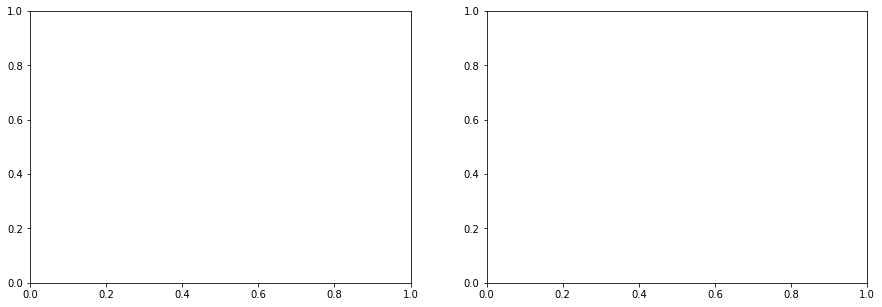

In [18]:
fig, ax = plt.subplots(1, 2, figsize=[15, 5])
ax[0].scatter(y_sc[:,0], y_sc[:, 1],  cmap='Accent', linewidths=0)
ax[0].set_title('Clusters obtained by Vanilla Spectral Clustering')

ax[1].scatter(y_rsc[0], y_rsc[0],  cmap='Accent', linewidths=0)
ax[1].set_title('Clusters obtained by Robust Spectral Clustering');

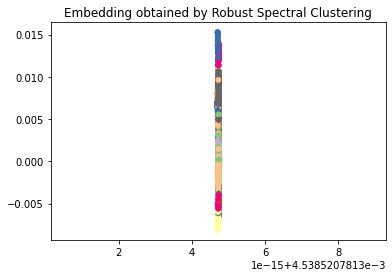

In [15]:
plt.scatter(rsc.H[:, 0], rsc.H[:, 1], c=y_rsc,  cmap='Accent', linewidths=0)
plt.title('Embedding obtained by Robust Spectral Clustering');

In [19]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_sc, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  86.659 %
     Precision:  95.659 %
        Recall:  79.017 %
      F1 score:  86.094 %


In [22]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_rsc, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1724
X_test size: 431 



In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  87.297 %
     Precision:  94.562 %
        Recall:  81.181 %
      F1 score:  86.866 %


In [24]:
from sklearn.metrics import silhouette_score

# centers = kmeans.cluster_centers_
score = silhouette_score (X, y_sc, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

NameError: ignored

In [29]:
data_all = df.copy()

data_all['cluster_sc'] = y_sc
data_all.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic,cluster_sc
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,2
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi,7
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation,12
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern,2
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern,7


In [30]:
data_all = data_all.copy()

data_all['cluster_rsc'] = y_rsc
data_all.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic,cluster_sc,cluster_rsc
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,2,7
1,1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi,7,17
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation,12,4
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern,2,7
4,4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern,7,17


In [31]:
data_all['cluster_sc'].value_counts()

2     796
1     215
7     171
5     146
12    133
15    102
16     98
4      76
18     61
8      51
11     49
19     40
10     38
14     33
9      33
0      31
3      24
17     23
13     19
6      16
Name: cluster_sc, dtype: int64

In [32]:
data_all['cluster_rsc'].value_counts()

7     787
18    207
17    171
13    143
4     135
1     118
8     103
5      78
19     58
12     50
2      46
16     42
14     35
9      34
15     34
11     31
6      24
0      22
10     21
3      16
Name: cluster_rsc, dtype: int64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


There are 52 news categories


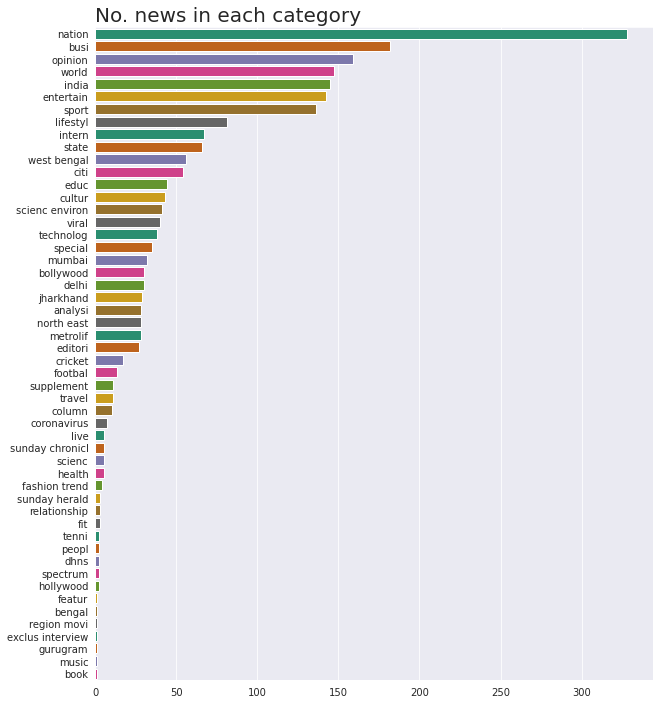

In [34]:
import seaborn as sns
#No. of contents in each category
count_df = pd.DataFrame(df['processed_topic'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='index', x='processed_topic', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

There are 20 news categories


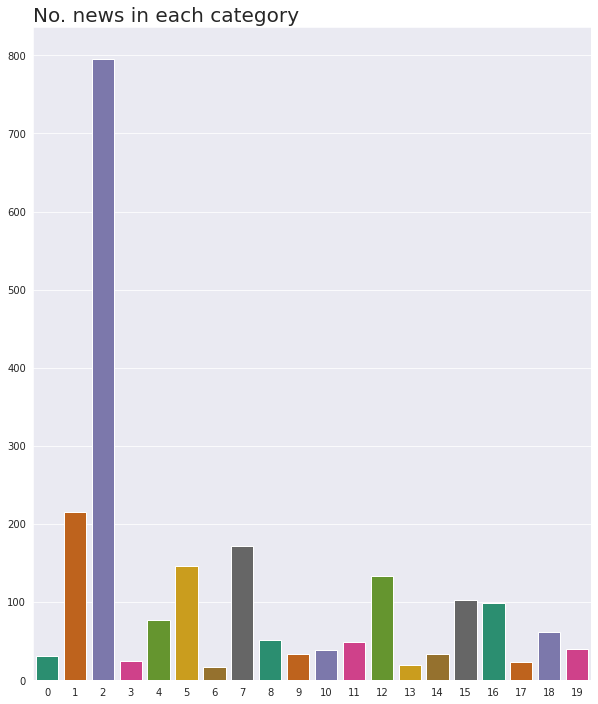

In [36]:
#No. of contents in each category
count_df = pd.DataFrame(data_all['cluster_sc'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='cluster_sc', x='index', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

In [43]:
data_all[data_all.processed_topic == 'nation']

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic,cluster_sc,cluster_rsc
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,2,7
2,2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation,12,4
5,5,5,5f04e4a1ef217aae6a201f76,"[""National""]","[""Andhra Pradesh police arrested 12 employees ...",andhra pradesh polic arrest employe polym incl...,nation,2,7
6,6,6,5f04e4a3ef217aae6a201f77,"[""National""]","[""Vaccine maker Serum Institute of India (SII)...",vaccin maker serum institut india hop develop ...,nation,8,12
8,8,8,5f04e4a8ef217aae6a201f79,"[""National""]","[""India remains cautious as China has not yet ...",india remain cautious china show sign thin lar...,nation,9,15
...,...,...,...,...,...,...,...,...,...
1182,1182,1259,5f230beffefd329f4a3d0d7a,"[""Nation""]","[""The Ministry of Home Affairs on Wednesday ex...",ministri home affair wednesday extend lockdown...,nation,2,7
1183,1183,1260,5f230bf2fefd329f4a3d0d7b,"[""Nation""]","[""New Delhi:"","" Sushant Singh Rajput's father ...",delhi sushant singh rajput father thursday fil...,nation,1,18
1185,1185,1262,5f230bf6fefd329f4a3d0d7d,"[""Nation""]","[""New Delhi: "",""The CBI has booked four Navy o...",delhi book navi offic alleg generat fake bill ...,nation,2,7
1186,1186,1263,5f230bf9fefd329f4a3d0d7e,"[""Nation""]","[""The Centre on Wednesday took a huge step tow...",centr wednesday take huge step wean india away...,nation,12,4


There are 20 news categories


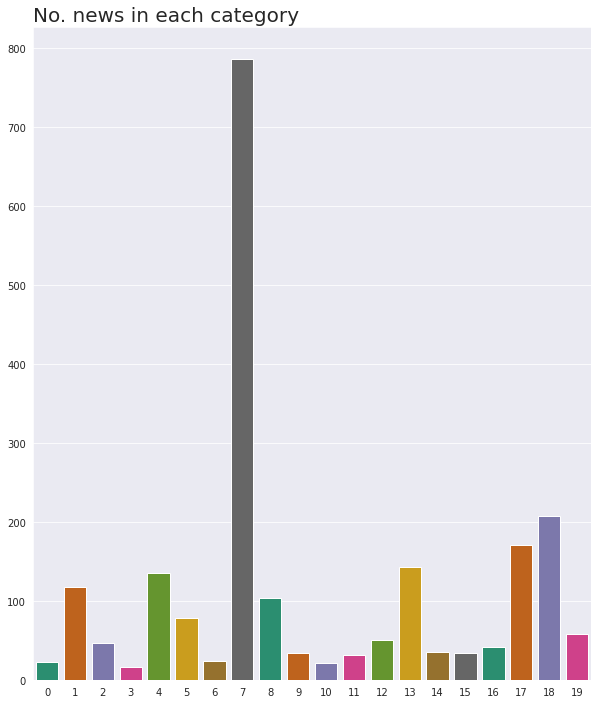

In [37]:
#No. of contents in each category
count_df = pd.DataFrame(data_all['cluster_rsc'].value_counts()).reset_index()
print('There are', len(count_df), 'news categories')

sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
sns.barplot(data=count_df, y='cluster_rsc', x='index', palette='Dark2')
plt.title('No. news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.show()

In [41]:
data_all[data_all.cluster_rsc == 7]

,Unnamed: 0,Unnamed: 0.1,_id,topic,content,processed_content,processed_topic,cluster_sc,cluster_rsc
0,0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,2,7
3,3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern,2,7
5,5,5,5f04e4a1ef217aae6a201f76,"[""National""]","[""Andhra Pradesh police arrested 12 employees ...",andhra pradesh polic arrest employe polym incl...,nation,2,7
7,7,7,5f04e4a5ef217aae6a201f78,"[""International""]","[""Brazil's President Jair Bolsonaro says he ha...",brazil presid jair bolsonaro say test posit co...,intern,2,7
9,9,9,5f04e4abef217aae6a201f7a,"[""National""]","[""In a trend that compounds concern, the total...",trend compound concern total number covid case...,nation,2,7
...,...,...,...,...,...,...,...,...,...
2144,2186,2852,5f04c5af2ba198f21c82c4ac,"[""world""]","[""The United States passed another grim corona...",unit state pass grim coronavirus mileston mond...,world,2,7
2145,2187,2853,5f04c5b12ba198f21c82c4ad,"[""world""]","[""The death toll due to the torrential rain in...",death toll torrenti rain japan kyushu region c...,world,2,7
2146,2188,2854,5f04c5b42ba198f21c82c4ae,"[""Cities""]","[""Hoteliers in Himachal Pradesh are divided ov...",hoteli himach pradesh divid open border touris...,citi,2,7
2147,2189,2855,5f04c5b62ba198f21c82c4af,"[""Cities""]","[""Himachal Pradesh State level Single Window M...",himach pradesh state level singl window monito...,citi,2,7
